In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = '/content/drive/MyDrive/Project/Kaggle TPS Mar 2021/'

In [62]:
df = pd.read_csv(PATH+'train.csv')
df_test = pd.read_csv(PATH+'test.csv')
df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [63]:
df_total = pd.concat([df, df_test])

In [64]:
df.isnull().any().any()

False

In [65]:
cols_cat = [f'cat{i}' for i in range(19)]
cols_cont = [f'cont{i}' for i in range(11)]

In [66]:
df_total[cols_cat+cols_cont].isnull().any().any()

False

In [67]:
df_total[cols_cat].nunique()

cat0       2
cat1      15
cat2      19
cat3      13
cat4      20
cat5      84
cat6      16
cat7      51
cat8      61
cat9      19
cat10    307
cat11      2
cat12      2
cat13      2
cat14      2
cat15      4
cat16      4
cat17      4
cat18      4
dtype: int64

In [68]:
df.describe()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,250183.425697,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,144320.334812,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,0.000000,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,125399.750000,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,250192.500000,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,375246.250000,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,499999.000000,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


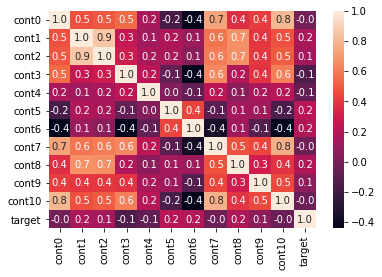

In [13]:
corr = df[cols_cont+['target']].corr()
ax = sns.heatmap(corr, annot=True, fmt='.1f')

In [69]:
from sklearn.preprocessing import LabelEncoder

for col in cols_cat:
    le = LabelEncoder()
    le.fit(df_total[col])
    df[col] = le.transform(df[col])
    df_test[col] = le.transform(df_test[col])
df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,0,8,0,1,1,33,0,44,54,0,266,0,0,0,0,1,3,3,1,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,0,8,0,0,4,33,8,48,3,5,167,0,1,0,1,3,1,3,1,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,0,10,0,0,4,33,0,30,38,9,73,0,1,0,0,1,3,3,1,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,0,10,0,2,4,33,0,50,3,5,249,0,0,0,0,1,3,3,1,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,0,8,6,1,4,33,2,32,54,0,79,0,0,0,1,1,1,3,1,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


# Model

In [70]:
import tensorflow as tf

In [80]:
input_layers = []
embed_layers = []
for col in cols_cat:
    n_cats = df_total[col].nunique()
    em_size = min((n_cats+1)//2,50)
    in_ = tf.keras.layers.Input(shape=(1,))
    em_ = tf.keras.layers.Embedding(n_cats, em_size)(in_)
    fl_ = tf.keras.layers.Flatten()(em_)
    input_layers.append(in_)
    embed_layers.append(fl_)

In [81]:
in_num = tf.keras.layers.Input(shape=(11,))
input_layers.append(in_num)
embed_layers.append(in_num)

In [83]:
merge = tf.keras.layers.concatenate(embed_layers)
dense = tf.keras.layers.Dense(60, activation='relu')(merge)
drop = tf.keras.layers.Dropout(.35)(dense)
dense2 = tf.keras.layers.Dense(30, activation='relu')(drop)
drop2 = tf.keras.layers.Dropout(.15)(dense2)
dense3 = tf.keras.layers.Dense(10, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(.15)(dense3)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop3)
model = tf.keras.Model(inputs=input_layers, outputs=output)

In [84]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['AUC'])

In [75]:
from sklearn.model_selection import train_test_split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df[cols_cat+cols_cont], df['target'], test_size=0.2)

In [86]:
model.fit([X_train[col] for col in cols_cat]+[X_train[cols_cont]], y_train, epochs=30, batch_size=1024,
          validation_data = ([X_test[col] for col in cols_cat]+[X_test[cols_cont]], y_test))

Epoch 1/30
235/235 [==============================] - 8s 19ms/step - loss: 0.4937 - auc: 0.7397 - val_loss: 0.3665 - val_auc: 0.8795
Epoch 2/30
235/235 [==============================] - 4s 18ms/step - loss: 0.3748 - auc: 0.8743 - val_loss: 0.3629 - val_auc: 0.8819
Epoch 3/30
235/235 [==============================] - 4s 17ms/step - loss: 0.3689 - auc: 0.8778 - val_loss: 0.3609 - val_auc: 0.8829
Epoch 4/30
235/235 [==============================] - 4s 17ms/step - loss: 0.3627 - auc: 0.8820 - val_loss: 0.3607 - val_auc: 0.8836
Epoch 5/30
235/235 [==============================] - 4s 17ms/step - loss: 0.3631 - auc: 0.8812 - val_loss: 0.3591 - val_auc: 0.8844
Epoch 6/30
235/235 [==============================] - 4s 18ms/step - loss: 0.3603 - auc: 0.8833 - val_loss: 0.3589 - val_auc: 0.8848
Epoch 7/30
235/235 [==============================] - 4s 17ms/step - loss: 0.3574 - auc: 0.8858 - val_loss: 0.3585 - val_auc: 0.8854
Epoch 8/30
235/235 [==============================] - 4s 17ms/step - 

In [87]:
y_pred = model.predict([df_test[col] for col in cols_cat]+[df_test[cols_cont]])
y_pred

array([[0.14100671],
       [0.27555788],
       [0.01408756],
       ...,
       [0.5886961 ],
       [0.11320752],
       [0.5021256 ]], dtype=float32)

In [88]:
sub = pd.read_csv(PATH+'sample_submission.csv')
sub['target'] = y_pred
sub.to_csv('sub_v2.csv', index=False)